# Healthier tasty recipes recommender system

> The following notebook sumarizes the work that have been accomplished during the project and aims to present our results the more concisely possible. Minimal explanations are given regarding the datasets and mapping in order to understand the analysis that has been conducted during the third part of the project.

> In each part, we will indicate where one needs to go to get a more in-depth understanding.

In [1]:
# Imports

import sys
import json
import h5py
import tables
import inflect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import models

# Import our .py scripts

sys.path.insert(0, "/home/luke/Github/Project/python")
#sys.path.insert(0, "../python")
#sys.path.insert(1, "/Users/Lionel/Documents/Ada/Project/python")

import one_m
import recommender as rc
import USDA_parsing as usda

In [2]:
def print_bold(str):
    print('\033[1m' + str + '\033[0m')

## 1. Preprocessing

>  The information used to train the recommender are retrieved from four different datasets, namely kaggle "what's cooking" (**WIC**), "From cookies to cooks" (**FCTC**), "1M Cooking recipes" (**1M**) and the "USDA food composition database"(**USDA**). WIC and FCTC contain 96763 recipes, for which they simply provide lists of ingredients.
1M is more complete, as it contains more than 1 million recipes. For each recipe and for each ingredient, a string encodes the ingredient name along with its quantity, a boolean indicates whether the ingredient can be found in USDA and a string gives the extracted ingredient name.
Finally, USDA contains no recipes, but provides a mapping between ingredient ID, description and nutrients composition. 

### 1.1 Look at the raw data

#### Recipes from the Kaggle dataset

In [3]:
# Load raw data
kaggle_train_raw = json.load(open('../data/kaggle/train.json'))  
kaggle_test_raw = json.load(open('../data/kaggle/test.json'))
    
print_bold("Number of recipes in the Kaggle dataset before cleaning: " + str(len(kaggle_train_raw) + len(kaggle_test_raw)))

print_bold("\n\nThis is an example of a dataset recipe entry : ")
kaggle_train_raw[0]

Number of recipes in the Kaggle dataset before cleaning: 49718


This is an example of a dataset recipe entry : 


{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

#### Recipes from the "From cookies to cooks" dataset

In [4]:
# Load raw data
cookies_to_cook_file = open("../data/recipeClean/ingredients.txt", mode='r', buffering=-1, encoding="ISO-8859-1", errors=None, newline=None, closefd=True, opener=None)
cookies_to_cook_raw = cookies_to_cook_file.readlines()

print_bold("Number of recipes in the \"From cookies to cooks\" dataset before cleaning: " + str(len(cookies_to_cook_raw)))


print_bold("\n\nThis is an example of a dataset recipe entry : ")
cookies_to_cook_raw[:1]

Number of recipes in the "From cookies to cooks" dataset before cleaning: 64249


This is an example of a dataset recipe entry : 


['20f6f98261da097ba0b6fe4ba159b3c1.html\tbettycrocker.com\thttp://www.bettycrocker.com/recipes/wild-rice-soup/1ca76b2d-c859-4083-bfdd-9f4549267675\tWild Rice Soup\t2 tablespoons butter or margarine|2 medium stalks celery, sliced (1 cup)|1 medium carrot, coarsely shredded (1 cup)|1 medium onion, chopped (1/2 cup)|1 small green bell pepper, chopped (1/2 cup)|3 tablespoons Gold medalÂ® all-purpose flour|1/4 teaspoon pepper|1 pouch (from 10-ounce package) frozen cooked wild rice (1 1/4 cups)|1 cup water|1 can (10 1/2 ounces) condensed chicken broth|1 cup half-and-half|1/3 cup slivered almonds, toasted, if desired|1/4 cup chopped fresh parsley\n']

#### Recipes from the 1M dataset

In [5]:
# Load raw data

recipes_1m_raw = json.load(open("../data/1M/recipe1M_layers/layer1.json"))    

print_bold("Number of recipes in the 1M dataset before cleaning: " + str(len(recipes_1m_raw)))


print_bold("\n\nThis is an example of a dataset recipe entry : ")
recipes_1m_raw[:1]

Number of recipe in the 1M dataset before cleaning: 1029720


This is an example of a dataset recipe entry : 


[{'ingredients': [{'text': '6 ounces penne'},
   {'text': '2 cups Beechers Flagship Cheese Sauce (recipe follows)'},
   {'text': '1 ounce Cheddar, grated (1/4 cup)'},
   {'text': '1 ounce Gruyere cheese, grated (1/4 cup)'},
   {'text': '1/4 to 1/2 teaspoon chipotle chili powder (see Note)'},
   {'text': '1/4 cup (1/2 stick) unsalted butter'},
   {'text': '1/3 cup all-purpose flour'},
   {'text': '3 cups milk'},
   {'text': '14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)'},
   {'text': '2 ounces semisoft cheese (page 23), grated (1/2 cup)'},
   {'text': '1/2 teaspoon kosher salt'},
   {'text': '1/4 to 1/2 teaspoon chipotle chili powder'},
   {'text': '1/8 teaspoon garlic powder'},
   {'text': '(makes about 4 cups)'}],
  'url': 'http://www.epicurious.com/recipes/food/views/-world-s-best-mac-and-cheese-387747',
  'partition': 'train',
  'title': 'Worlds Best Mac and Cheese',
  'id': '000018c8a5',
  'instructions': [{'text': 'Preheat the oven to 350 F. Butter or oil an 8-in

### 1.2 The cleaning procedure

The cleaning procedure allows us to have meaningful ingredients to use but also to standardizes the ingredients from each dataset <br>

Summary of the procedure: <br>
- remove parenthesis and their content
- remove a set of special characters
- remove dangling letters
- remove the digits
- remove commas and everything that follow them
- remove a set of words considered as garbage (to_remove file)
- remove the adjectives (e.g. sliced, seared, ...)
- remove the alternative (everything that come after a 'or' is discarded)
- split ingredients that contains the word 'and' into two ingredients
- singularize every word


You can look into this procedure more in-depth either in the clean_recipes_datasets [notebook](TO_INSERT) or in the clean_recipes_datasets python [script](TO_INSERT) from which we use a few functions accross our scripts.

Note that we remove a recipe if, after the cleaning phase, none of its original ingredients remained non-empty.

### 1.3 Look at the data after cleaning

#### Recipes from the Kaggle dataset

In [7]:
kaggle = json.load(open('../generated/clean_kaggle.json'))  
    
# Number of recipes in the cleaned dataset
print_bold("Number of recipes in the Kaggle dataset after cleaning: " + str(len(kaggle))+ " (it was 49718 before)")

# Example of a cleaned dataset entry
print_bold("\n\nThis is an example of a cleaned dataset recipe entry : ")
kaggle[0]

Number of recipe in the Kaggle dataset after cleaning: 49718 (it was 49718 before)


This is an example of a cleaned dataset recipe entry : 


['romaine lettuce',
 'black olife',
 'grape tomato',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo bean',
 'feta cheese']

> The structure of the JSON is changed to keep only the ingredients. The cleaning procedure has singularized each ingredient.

#### Recipes from the "From cookies to cooks" dataset

In [8]:
cookies_to_cooks = json.load(open('../generated/clean_cookies.json'))  


# Number of recipes after cleaning
print_bold("Number of recipes in the \"From cookies to cooks\" dataset after cleaning: " + str(len(cookies_to_cooks)) + " (it was 64249 before)")

# Example of a cleaned entry
print_bold("\n\nThis is an example of a cleaned dataset recipe entry : ")
cookies_to_cooks[0]

Number of recipe in the "From cookies to cooks" dataset after cleaning: 47045(it was 64249 before)


This is an example of a cleaned dataset recipe entry : 


['butter',
 'stalks celery',
 'carrot',
 'onion',
 'green bell pepper',
 'gold medalâ® all-purpose flour',
 'pepper',
 'rice ',
 'water',
 'chicken broth',
 'half-and-half',
 'almond',
 'parsley']

> This dataset is the one that required the most cleaning. After cleaning, we lost 27% of the recipes

#### Recipes from the 1M dataset

In [9]:
recipes_one_m = json.load(open('../generated/clean_1m.json'))  
    
# Number of recipes after cleaning
print_bold("Number of recipes in the 1M dataset after cleaning: " + str(len(recipes_one_m)) + " (it was 1029720 before)")

# Example of a cleaned entry
print_bold("\n\nThis is an example of a cleaned dataset recipe entry : ")
recipes_one_m[0]

Number of recipes in the 1M dataset after cleaning: 869654 (it was 1029720 before)


This is an example of a cleaned dataset recipe entry : 


['elbow macaroni',
 'american cheese',
 'celery',
 'green pepper',
 'pimento',
 'mayonnaise',
 'vinegar',
 'salt',
 'dill weed']

> We lost 15% of the recipes from this dataset during the cleaning procedure. Note that this time we keep only the ingredients that can be mapped to the USDA database, that's why we lose a considerable quantity of recipes. <br>Why don't we filter the same way the ingredients in the other datasets ? We do, but latter, when the USDA mapping is implemented. 



## 2. Data analysis

In this part we give an intuition of the recipes composition and the ingredients distribution.

In [10]:
# We merge our three datasets into one
all_recipes = kaggle + cookies_to_cooks + recipes_one_m

#### 2.1 Number of ingredients per recipe

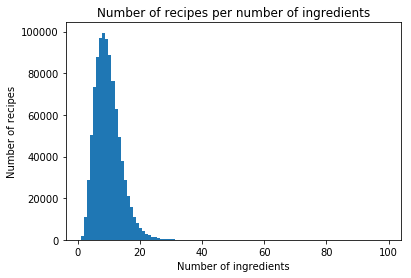

The median number of ingredients in a recipe is: 9
The maximum of ingredients in a recipe is: 99


In [13]:
# Count of ingredients for each recipe
counts = list(map(lambda r: len(r),all_recipes))

# Sort the counts
counts = sorted(counts, reverse=True)

# Plot the distribution of counts
plt.hist(counts, bins=100)
plt.title('Number of recipes per number of ingredients')
plt.xlabel('Number of ingredients')
plt.ylabel('Number of recipes')
plt.show()

print_bold('The median number of ingredients in a recipe is '+str(counts[int(len(counts)/2)]))
print_bold('The maximum of ingredients in a recipe is '+str(counts[0]))

> We see that the median number of ingredients is 9, which is not surprising. The distribution seems to be a gaussian with mean 9 and standard deviation of approximately 5. The maximum number of ingredients, 99, can be explained by recipes giving 'sub-recipes' for their ingredients. 

#### 2.2 Number of unique ingredients

In [14]:
all_ingr = []
for r in all_recipes:
    for i in r:
        all_ingr.append(i)
        
df_recipe = pd.Series(all_ingr)

print_bold('There are ' + str(len(df_recipe.unique())) + ' distinct ingredients')

There are 38182 distinct ingredients


> This is a huge number of ingredients, even considering our number of recipes. It is likely that a lot of ingredients are in fact some noise that we failed to filter during the parsing. Also, it is likely that several ingredients refer to the same ingredient but are written in different ways (e.g. "white rice" and "long-grain white rice"). <br>
To confirm, we look at the distribution of the ingredients.

#### 2.3 Distribution of the ingredients

Below, we sort the ingredients by the number of times they appear in the recipes

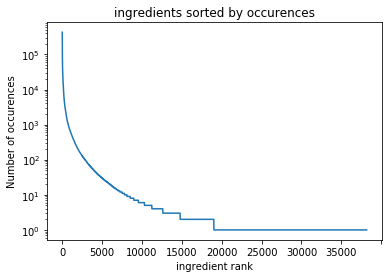

In [26]:
count_table = df_recipe.value_counts().to_frame().rename({0:'count'}, axis = 1)

# Log scale
ax = count_table['count'].plot(logy=True)
ax.set_xlabel('ingredient rank')
ax.set_ylabel('Number of occurences')
ax.set_title('ingredients sorted by occurences')
ax.set_xticklabels([0] + [5000*i for i in range(8)])
plt.show()

> Indeed, a lot of ingredients appear only a few times, actually not enough times for the embeddings to build accurate vector representations. Therefore, we decided to keep only the ingredients that appear in more than 15 recipes.

In [33]:
# The ingredients that appear more than 15 times 
without_junk = count_table[count_table['count'] > 15]
print_bold("We keep "+ "{:.2f}".format(100*((without_junk['count'].sum()) / count_table.sum())[0])+\
      "% of the data if we discard ingredients that appear in less than 15 recipes.")

print_bold("The number of distinct ingredients is now " + str(len(without_junk)) +\
           " (reduced by a factor " + "{:.3}".format(len(count_table) / len(without_junk)) +").")

We keep 99.13% of the data if we discard ingredients that appear in less than 15 recipes.
The number of distinct ingredients is now 6599 (reduced by a factor 5.79).


> We see that removing those ingredients does not damage the data so much, but allows us to reduce the number of ingredients in a very effective way.

## 3. USDA Mapping

#### 3.1 USDA database

> This section aims to give an insight on the work that has been done on the USDA mapping that is necessary for  the analysis conducted below. To get a more in-depth understanding, one can either consult the [USDA_parsing.ipnyb](USDA_parsing.ipynb) notebook or the [USDA_parsing.py](../python/USDA_parsing.py) source file.

To get the nutrients of each recipes, our approach consists in linking the different ingredients of a recipe to an entry of the USDA database. As every ingredient does not match exactly the description of a USDA, we implemented a notion of score that indicates how well the ingredients match the entries of the database.

In [15]:
# Relevant data for USDA
food_des_path = "./../data/usda/FOOD_DES.txt"
food_groups_path = "./../data/usda/FD_GROUP.txt"
nut_data_path = "./../data/usda/NUT_DATA.txt"
nut_def_path = "./../data/usda/NUTR_DEF.txt"

all_paths = [food_des_path, food_groups_path, nut_data_path, nut_def_path]

In [16]:
# Generate singularization engine
engine = inflect.engine()

# Columns we want to retrieve from the database files
columns = ["food_id", "food_group_id", "long_description", "common_names"]
use_cols = [0, 1, 2, 4]

# Get the info from file
food_des = pd.read_csv(food_des_path, sep="^", encoding="ISO-8859-1", names=columns, usecols=use_cols, header=None)

# Display original table format
print_bold("original table format : ")
print(food_des.head())


# Generate search_words
food_des['search_words'] = food_des.apply(lambda row : usda.concat_common_and_des(usda.format_long_des(row['common_names'], engine),
                                                                                  usda.format_long_des(row['long_description'], engine)),
                                                                                  axis=1)

# Drop common_names column
food_des = food_des.drop("common_names", axis=1)
            
print_bold("\n\nnew table format")
food_des.head()

original table format : 
   food_id  food_group_id            long_description common_names
0     1001            100              Butter, salted          NaN
1     1002            100  Butter, whipped, with salt          NaN
2     1003            100       Butter oil, anhydrous          NaN
3     1004            100                Cheese, blue          NaN
4     1005            100               Cheese, brick          NaN


new table format


,food_id,food_group_id,long_description,search_words
0,1001,100,"Butter, salted","[butter, salted]"
1,1002,100,"Butter, whipped, with salt","[butter, whipped, salt]"
2,1003,100,"Butter oil, anhydrous","[butter, oil, anhydrou]"
3,1004,100,"Cheese, blue","[cheese, blue]"
4,1005,100,"Cheese, brick","[cheese, brick]"


> The original table format is an extract of the USDA database. As it is not likely we have an ingredient matching the long description, we generate from the long description a set of search words. Those words are obtained by splitting the sentence by words, singularizing them and removing,... The ones that give no information (e.g. "with"). This is what we can observe in the "new table format"

#### 3.2 Search function

In [17]:
def search_score(categories, ing_words) :
    # singularize search words
    ing_words = set([singularize_word(x) for x in ing_words])

    #prioritize matching query terms
    nb_matching = len(ing_words.intersection(set(categories)))

    #non_complexificators should not be penalized,ignore them AFTER computing number of matching words
    categories = [c for c in categories if (c not in non_complexificators)]


    #matching keywords one by one 
    matching = [len(set([x]).intersection(ing_words)) != 0 for x in categories]


    #first keywords are more important
    weights = np.linspace(2, 1, num=len(matching))
    weights = weights / sum(weights)

    #the query should have as many ingredients words as possible
    score = (10 * nb_matching) + sum([c[0] * c[1] for c in zip(matching, weights)])

    return score

>The design of the score function starts from three straightforward observations, namely :
- Lots of categories usually mean complex food item
- Categories are ordered by descending relevance
- Some categories (e.g ’raw’) do not make the food item more complex

>Note that the ’categories’ that do not make the food-item more complex were chosen empirically.

#### 3.3 Examples

In [18]:
# Raw categories
print(usda.search_ingredient('raw chicken', food_des, engine))
print(usda.search_ingredient('chicken', food_des, engine))

# Plurial word
print(usda.search_ingredient('fresh tomatoes', food_des, engine))

# Nationality categories
print(usda.search_ingredient('italian cheese', food_des, engine))

# Composite ingredients
print(usda.search_ingredient('pepper and salt', food_des, engine))

(      food_id            search_words  search_score
1043     5332  [chicken, ground, raw]     20.666667, 20.666666666666668)
(      food_id        search_words  search_score
7670    43128  [chicken, meatles]     10.666667, 10.666666666666666)
(      food_id           search_words  search_score
2928    11695  [tomato, orange, raw]     10.666667, 10.666666666666666)
(      food_id                                       search_words  search_score
7517    36055  [restaurant, italian, cheese, ravioli, marinar...     20.377778, 20.377777777777776)
(      food_id                                    search_words  search_score
2897    11632  [pepper, jalapeno, canned, solid, and, liquid]     20.355556, 20.355555555555554)


> As we can see:
- The word 'raw does not penalize the matching, even the opposite as it allows to match a entry of the USDA more exactly.
- Tomatoes can be mapped on tomato
- Words like nationalities can produce noises in the search_words, even so the most important word is in third place
- If two ingredients are given we can match the first one

#### 3.4 Final mapping

In [19]:
mapping_usda_id = json.load(open('../generated/ing_id_mapping.json'))  

mapping_usda_id['chicken']

43128

> The USDA_parsing notebook and script produce a ingredient mapping as a dictionary. The ingredient chicken is mapped on the USDA id 43128: [Chicken, meatless](https://ndb.nal.usda.gov/ndb/foods/show/43128?fgcd=&manu=&format=&count=&max=25&offset=&sort=default&order=asc&qlookup=43128&ds=&qt=&qp=&qa=&qn=&q=&ing=)

# Need to explain representative somewhere

## 4. Embeddings

In [20]:
# Imports the generated files needed by the embedding

# Trained model that is used to compute the similirity between two ingredients
food_embeddings = models.Word2Vec.load('../generated/food_embeddings.bin')

In [21]:
food_embeddings.wv.most_similar('rice')

/home/luke/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('long-grain rice', 0.7261274456977844),
 ('long-grain white rice', 0.6468431949615479),
 ('raw rice', 0.6448583006858826),
 ('vermicelli', 0.641447901725769),
 ('soba noodle', 0.5858522057533264),
 ('spanish rice mix', 0.5729177594184875),
 ('brown rice flour', 0.5379102826118469),
 ('rice blend', 0.5375496745109558),
 ('grain rice', 0.5310273170471191),
 ('egg noodle', 0.5279222726821899)]

In [22]:
food_embeddings.wv.most_similar('butter')

[('margarine', 0.6484322547912598),
 ('heavy cream', 0.5509346723556519),
 ('cream', 0.512773871421814),
 ('whipping cream', 0.5074151158332825),
 ('shortening', 0.47044312953948975),
 ('flour', 0.42905911803245544),
 ('milk', 0.42751216888427734),
 ('egg yolk', 0.41097086668014526),
 ('yolk', 0.3897933065891266),
 ('shortbread', 0.38087165355682373)]

In [23]:
food_embeddings.wv.most_similar('lettuce')

[('iceberg lettuce', 0.8824388384819031),
 ('romaine lettuce', 0.8092721700668335),
 ('green lettuce', 0.7680988311767578),
 ('salad green', 0.7646308541297913),
 ('green', 0.6246930360794067),
 ('salad dressing', 0.6189268231391907),
 ('cucumber', 0.5564990043640137),
 ('coleslaw', 0.5390306711196899),
 ('radish', 0.5378662943840027),
 ('avocado', 0.5250253677368164)]

## 5. Recommender

> This section shows the result of our recommender described in our [report](). Its implementation can be consulted in [recommender.py](TO_INSERT). The word embedding model is trained and generated in the  [Food_Embeddings.ipnyb](TO_INSERT) notebook.

#### 5.1 Recommender applied on recipes from our dataset.

To show our results, we chose 3 recipes on which we are going to apply our recommender to see its efficiency.

In [24]:
recipes_quant = json.load(open('../generated/recipes_quantities_mapped_usda.json'))

In [25]:
recipes_quant

[[[128.0, 20421],
  [128.0, 43278],
  [64.0, 11143],
  [64.0, 11333],
  [42.900000000000006, 11943],
  [64.0, 43598],
  [14.3, 2069],
  [3.1500000000000004, 2047],
  [2.1, 2045]],
 [[224.0, 1286], [128.0, 9316], [32.0, 21463]],
 [[256.0, 16166],
  [128.0, 9050],
  [128.0, 20033],
  [64.0, 28309],
  [64.0, 12142],
  [128.0, 1295]],
 [[320.0, 20649],
  [64.0, 20033],
  [14.3, 19334],
  [28.6, 11297],
  [150, 9004],
  [72, 11124],
  [50, 1123],
  [42.666666666666664, 4669],
  [96.0, 14555]],
 [[14.3, 20027],
  [28.6, 14555],
  [1536.0, 14555],
  [4.2, 9152],
  [33, 1124],
  [85.80000000000001, 19908]],
 [[4352.0, 42291],
  [1536.0, 19908],
  [4.2, 2050],
  [50.400000000000006, 2047],
  [224.0, 1212],
  [288.0, 20649],
  [16.8, 18371]],
 [[168.0, 1253], [1664.0, 1212], [58.800000000000004, 11805], [0.05, 6169]],
 [[42.0, 19093], [14.3, 1212], [192.0, 1287]],
 [[192.0, 19908],
  [96.0, 20084],
  [32.0, 19165],
  [192.0, 1124],
  [128.0, 19908],
  [1.05, 2047],
  [384.0, 19097]],
 [[128.0, 2

In [27]:
recipe1_bis = ['1.0 lb lean ground beef',
           '1.0 onion',
           '1 tsp chili powder',
           '0.5 tsp salt',
           '0.5 tsp garlic powder',
           '8 oz tomato sauce',
           '10 oz taco shells',
           '6 ounce cheddar cheese',
           '2 c. lettuce',
           '2 tomatoes',
           '0.75 c. salsa',
           '0.75 c. sour cream']

# Oui
recipe2 = ['384.0 g flour',
           '256.0 g turbinado sugar',
           '2.1 g cinnamon',
           '2.1 g clove',
           '2.1 g nutmeg',
           '96.0 g butter',
           '256.0 g buttermilk',
           '4.2 g baking soda',
           '128.0 g raisin',
           '128.0 g pistachio nut']

recipe3 = ['256.0 g flour',
          '28.6 g baking soda',
          '2.1 g salt',
          '14.3 g margarine',
          '1.05 g baking soda',
          '128.0 g buttermilk',
          '64.0 g cooking spray']

recipe4 = ['100.0 g beef',
           '1 carrot',
           '200 g pasta',
           '30 g cheese',
           '4 tomatoes']

recipe4 = ['100.0 g bacon',
           '10 g pepper',
           '200 g pasta',
           '30 g cheese',
           '4 eggs']

recipe5 = ['100 g summer squash',
           '100 g water',
           '5 g salt']

recipe1_bis = [one_m.extract_quantity_from_raw(ingr) for ingr in recipe1_bis]
recipe1_bis = [[i[0],i[1],i[2]] for i in recipe1_bis]

recipe2 = [one_m.extract_quantity_from_raw(ingr) for ingr in recipe2]
recipe2 = [[i[0],i[1],i[2]] for i in recipe2]

recipe3 = [one_m.extract_quantity_from_raw(ingr) for ingr in recipe3]
recipe3 = [[i[0],i[1],i[2]] for i in recipe3]

recipe4 = [one_m.extract_quantity_from_raw(ingr) for ingr in recipe4]
recipe4 = [[i[0],i[1],i[2]] for i in recipe4]

recipe5 = [one_m.extract_quantity_from_raw(ingr) for ingr in recipe5]
recipe5 = [[i[0],i[1],i[2]] for i in recipe5]



In [28]:
rc.find_swapping(recipe5)

your recipe is 3.98 % healthier if you replace summer squash with yellow pepper


('summer squash', 'yellow pepper')